<a href="https://colab.research.google.com/github/akankshakusf/Multi-Agent-Langraph-with-AstraDB/blob/master/AgenticAI_Langraph_With_Astradb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Agent Project Layout

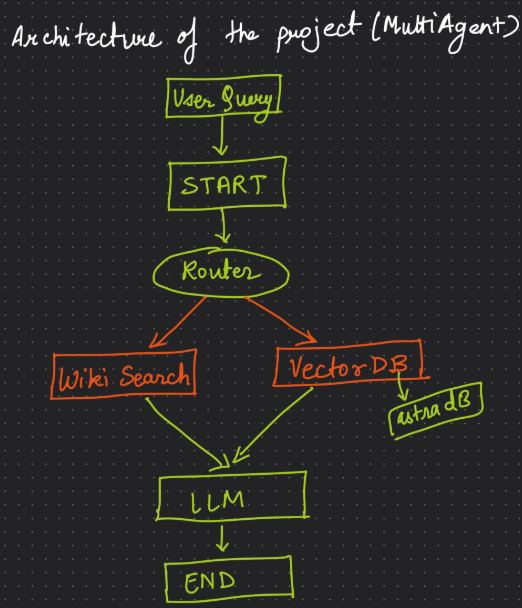


# Implementing Cassandra Astra Vector Store db Component from Layout

In [1]:
#import packages
!pip install langchain langgraph cassio langchain_community langchain_groq langchainhub langchain_huggingface tiktoken Wikipedia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.2/122.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [35]:
#import keys and astradb
import cassio
from google.colab import userdata

#connection of the astra db
ASTRA_DB_APPLICATION_TOKEN=userdata.get("ASTRA_DB_APPLICATION_TOKEN")
ASTRADB_CLIENT_ID=userdata.get("ASTRADB_CLIENT_ID")

#import hugging face token
HF_TOKEN=userdata.get("HF_TOKEN")
groq_api_key=userdata.get("GROQ_API_KEY")

In [36]:
#initiailize astradb
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRADB_CLIENT_ID)

In [37]:
#build index
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

#load documents
docs=[WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]

#split to chunks
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits=text_splitter.split_documents(docs_list)

In [38]:
#Import embeddings
from langchain_huggingface import HuggingFaceEmbeddings

#initialize embeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [39]:
#import vector store
from langchain.vectorstores import Cassandra

#initialize vector store
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_test",
    session=None,
    keyspace=None
)

In [40]:
#import wrapper for vectorstore
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

#push data
astra_vector_store.add_documents(doc_splits)
print("Inserted %i Headlines." % len(doc_splits))

#intialise wrapper
astra_vector_index=VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 Headlines.


In [41]:
# initialize retriever
retriever=astra_vector_store.as_retriever()

#invoke the retriever
retriever.invoke("What is an agent?")

[Document(id='eee7dab4416245db990c36b9a044ed48', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

# Implementation of Wikipedia Component

In [42]:
### Working With Tools
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

##wikipedia Tools
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [43]:
#lets test wiki
wiki.run("What is Agent")

'Page: Intelligent agent\nSummary: In artificial intelligence, an intelligent agent is an entity that perceives its environment, takes actions autonomously to achieve goals, and may improve its performa'

Great! Wiki Search seems to be working fine

# Implementing Router Component of Layout

In [44]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [45]:
# Base Model Class
class RouteQuery(BaseModel):
  """Route a user query to the most relevant datasource."""
  datasource: Literal["vectorstore","wiki_search"] = Field(
      ...,
      description="Given a user question Choose to route to wikipedia or a vectorstore."
  )


In [46]:
#import the llm
from langchain_groq import ChatGroq

#initialize llm
llm=ChatGroq(model_name="Gemma2-9b-It", groq_api_key=groq_api_key)
structured_llm_router=llm.with_structured_output(RouteQuery)
structured_llm_router

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ecf5620b6d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ecf56b801d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'RouteQuery', 'description': 'Route a user query to the most relevant datasource.', 'parameters': {'type': 'object', 'properties': {'datasource': {'description': 'Given a user question Choose to route to wikipedia or a vectorstore.', 'enum': ['vectorstore', 'wiki_search'], 'type': 'string'}}, 'required': ['datasource']}}}], 'ls_structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'RouteQuery', 'description': 'Route a user query to the most relevant datasource.', 'parameters': {'type': 'object', 'properties': {'datasource': {'description': 'Given a user question Choose to route to w

In [47]:
#generate the prompt for LLM to understand instructions
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

#initialize template
route_prompt=ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)


In [48]:
#create chain
question_router=route_prompt |structured_llm_router
question_router

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an expert at routing a user question to a vectorstore or wikipedia.\nThe vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.\nUse the vectorstore for questions on these topics. Otherwise, use wiki-search.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ecf5620b6d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ecf56b801d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'

In [49]:
#router test 1
print(question_router.invoke(
   {
       "question":"Who is Tom Cruise?"
   }
))

datasource='wiki_search'


In [50]:
#router test 2
print(question_router.invoke(
    {
        "question":"What is an agent?"
    }
))

datasource='vectorstore'


Great! Router seems to be working fine

# Implementing chatbot Agents using Langgraph

In [53]:
#graph
from typing import List
from typing_extensions import TypedDict


#graph class
class GraphState(TypedDict):
  """
  Represents the state of our grapgh

  Attributes:
    question:question
    generation:LLM generation
    documents:List of documents
  """

  question: str
  generation: str
  documents: List[str]

# Now we will execute each action through "state functions"
#### the 3 functions used are :
* retriver state f/c
* wiki-search state f/c
* router state f/c

In [54]:
#retrive function
from langchain.schema import Document #understand data is in chuncks right now in vec db we will fetch it after coming chunks to Documents

def retrieve(state):
  """
  Retrieve Documents function

  Args:
    state(dict): The Current graph State

  Returns:
    state(dict): New key added to state, documents, that contains retrieved documents
  """
  print("-----RETRIEVE------")

  question=state["question"]

  #retrieval : done through invoking retriever
  documents=retriever.invoke(question)
  return {"documents":documents,"question":question}

In [55]:
# wiki search fucntion
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("-----wikipedia------")

    question=state["question"]
    print(question)

    #wiki search activated by invoking
    docs=wiki.invoke({"query":question})
    wiki_results=docs
    wiki_results=Document(page_content=wiki_results)
    return {"documents":wiki_results,"question":question}



In [56]:
#router function
def route_question(state):
  """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
  """
  print("-----ROUTE QUESTION------")

  question=state["question"]

  #activate router by invoking it
  source=question_router.invoke({"question":question})
  if source.datasource=="wiki_search":
    print("----ROUTED QUESTION TO WIKI SEARCH----")
    return "wiki_search"
  elif source.datasource=="vectorstore":
    print("----ROUTED QUESTION TO RAG VECTORSTORE----")
    return "vectorstore"



# Implementing Final Work Flow of Graph

In [57]:
from langgraph.graph import START,StateGraph,END

#defining the flow
workflow=StateGraph(GraphState)

#defining nodes
workflow.add_node("wiki_search",wiki_search)
workflow.add_node("retrieve",retrieve)

#build the graph
#I am using condition edges since component interaction is bidirectional
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorstore":"retrieve"
    },
)

# defining END edge
workflow.add_edge("retrieve",END)
workflow.add_edge("wiki_search",END)


#now compile the work flow
app=workflow.compile()


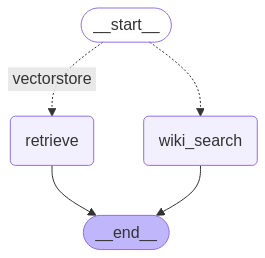

In [58]:
# i took this code from documentation "https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-5-customizing-state"
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Testing Application

In [59]:
from pprint import pprint

#run
inputs={
    "question":"What is an agent?"
    }
for output in app.stream(inputs):
  for key, value in output.items():
    #node
    pprint(f"Node '{key}: ")
  pprint("\n---\n")

#final generation
pprint(value['documents'][0].dict()['metadata']['description'])

-----ROUTE QUESTION------
----ROUTED QUESTION TO RAG VECTORSTORE----
-----RETRIEVE------


"Node 'retrieve: "
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\n'
 'Memory\n'
 '\n'
 'Short-term memory: I wo

<ipython-input-59-bd5d4f30cb9f>:14: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [61]:
from pprint import pprint

#run
inputs={
    "question":"Who is Captain America?"
    }
for output in app.stream(inputs):
  for key, value in output.items():
    #node
    pprint(f"Node '{key}: ")
  pprint("\n---\n")

# Final generation
pprint(value['documents'])

-----ROUTE QUESTION------
----ROUTED QUESTION TO WIKI SEARCH----
-----wikipedia------
Who is Captain America?
"Node 'wiki_search: "
'\n---\n'
Document(metadata={}, page_content='Page: Captain America in film\nSummary: Captain America, a  superhero created by Joe Simon and Jack Kirby who appears in comic books produced by Marvel Comics, has appeared in multiple films since the ')


# Dynamic input handling

In [80]:
from pprint import pprint

# Run query
inputs = {
    "question": "what are agents?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Print node source
        pprint(f"Node '{key}: ")
        pprint("\n---\n")

        # Check if documents is a list or a single object
        document = value['documents']

        # If it's a list, get the first element
        if isinstance(document, list) and len(document) > 0:
            document = document[0]

        # Check if metadata and description exist (Vector Store)
        if hasattr(document, "metadata") and "description" in document.metadata:
            pprint(document.metadata["description"]) # vec store  Search results
        else:
            pprint(document)  # Wiki Search results


-----ROUTE QUESTION------


----ROUTED QUESTION TO RAG VECTORSTORE----
-----RETRIEVE------
"Node 'retrieve: "
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final resu